In [2]:
!pip install torch torchvision pillow efficientnet-pytorch scikit-learn matplotlib seaborn



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import json
import subprocess

import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


✅ Using device: cuda


In [4]:
DISEASE_KNOWLEDGE = """

SECTION 1 — DISEASE KNOWLEDGE (15 CLASSES)

Pepper Bell Bacterial Spot:
- Symptoms: Small dark water-soaked spots on leaves and fruits, yellow halos, leaf drop.
- Cause: Xanthomonas bacteria.
- Organic Control: Neem oil (5 ml/L), copper spray (2 g/L).
- Chemical Control: Copper oxychloride (3 g/L), streptomycin sprays.
- Prevention: Disease-free seeds, crop rotation, avoid overhead watering.
- Fertilizer Recommendation: Balanced NPK 10-10-10.
- Climate Conditions: High humidity, warm temperature (25–30°C).
- Confusion With: Magnesium deficiency, sunscald.

Pepper Bell Healthy:
- Condition: Normal deep-green leaves, strong stems.
- Fertilizer Recommendation: NPK 12-12-17 every 25 days.
- Prevention: Proper irrigation, balanced fertilizer.

Potato Early Blight:
- Symptoms: Brown concentric rings on lower leaves, yellowing.
- Cause: Alternaria solani.
- Organic Control: Neem oil (3 ml/L).
- Chemical Control: Mancozeb (2.5 g/L).
- Prevention: Crop rotation, avoid overhead irrigation.
- Fertilizer Recommendation: NPK 5-10-20.

Potato Healthy:
- Condition: Dark green leaves, strong stems.
- Prevention: Adequate nitrogen, well-drained soil.
- Fertilizer Recommendation: NPK 13-40-13 at planting → 20-20-20.

Potato Late Blight:
- Symptoms: Dark greasy lesions, white mold under leaves, tuber rot.
- Cause: Phytophthora infestans.
- Organic Control: Neem oil (4 ml/L), copper oxychloride (3 g/L).
- Chemical Control: Mancozeb, Metalaxyl.
- Prevention: Remove infected plants, avoid water stagnation.
- Climate Conditions: Cool + humid weather.

Tomato Bacterial Spot:
- Symptoms: Small dark leaf spots, scabby fruits.
- Cause: Xanthomonas bacteria.
- Organic Control: Neem oil, copper sprays.
- Chemical Control: Copper fungicides.
- Prevention: Avoid overhead watering.
- Fertilizer Recommendation: NPK 5-10-10.

Tomato Early Blight:
- Symptoms: Concentric brown rings, leaf yellowing.
- Cause: Alternaria solani.
- Organic Control: Compost tea, neem oil.
- Chemical Control: Mancozeb, chlorothalonil.
- Prevention: Remove infected leaves.
- Fertilizer Recommendation: NPK 10-20-20.

Tomato Late Blight:
- Symptoms: Greasy lesions, white mold under leaves.
- Cause: Phytophthora infestans.
- Organic Control: Neem, copper oxychloride.
- Chemical Control: Mancozeb, Metalaxyl.
- Prevention: Remove infected plants.
- Fertilizer Recommendation: Increase potassium.

Tomato Leaf Mold:
- Symptoms: Yellow patches on top of leaf, olive mold underside.
- Cause: Passalora fulva.
- Organic Control: Pruning, ventilation, neem spray.
- Chemical Control: Copper or chlorothalonil fungicides.
- Prevention: Reduce humidity.

Tomato Septoria Leaf Spot:
- Symptoms: Numerous small brown spots with pale centers.
- Cause: Septoria lycopersici.
- Organic Control: Neem spray.
- Chemical Control: Copper fungicide.
- Prevention: Avoid overhead watering.

Tomato Spider Mites:
- Symptoms: Leaf bronzing, tiny webs, yellow speckles.
- Cause: Mites.
- Organic Control: Neem oil (2 ml/L), soap spray.
- Prevention: Increase humidity.

Tomato Target Spot:
- Symptoms: Circular spots with rings.
- Cause: Corynespora cassiicola.
- Organic Control: Neem, sanitation.
- Chemical Control: Fungicides.
- Prevention: Good airflow.

Tomato Mosaic Virus:
- Symptoms: Mottled leaves, twisted shape.
- Cause: Tomato mosaic virus.
- Organic Control: Remove infected plants.
- Prevention: Sanitize tools.

Tomato Yellow Leaf Curl Virus:
- Symptoms: Yellow curled leaves, stunting.
- Cause: Whitefly-transmitted virus.
- Organic Control: Sticky traps, neem oil.
- Prevention: Remove infected plants.

Tomato Healthy:
- Condition: Healthy green leaves, no visible spots, good vigor.
- Prevention: Proper irrigation, balanced fertilizer, good spacing.
- Fertilizer Recommendation: NPK 12-12-36 during fruiting stage.
- Climate Conditions: Warm, moderate humidity.

===========================================
SECTION 2 — NUTRIENT DEFICIENCIES
===========================================

Nitrogen Deficiency:
- Symptoms: Pale yellow older leaves.
- Fix: Compost, cow manure, urea (1 tsp/L).
- Prevention: Regular compost application.

Phosphorus Deficiency:
- Symptoms: Purplish leaves, slow growth.
- Fix: DAP, bone meal.
- Prevention: Maintain soil pH 6–7.

Potassium Deficiency:
- Symptoms: Brown leaf edges (scorching).
- Fix: MOP fertilizer.
- Prevention: Balanced NPK schedule.

Calcium Deficiency:
- Symptoms: Blossom end rot.
- Fix: Calcium nitrate (1 tsp/L).
- Prevention: Avoid irregular watering.

Magnesium Deficiency:
- Symptoms: Yellowing between veins on older leaves.
- Fix: Epsom salt spray (1 tsp/L).
- Prevention: Maintain soil pH 6–7.

Iron Deficiency:
- Symptoms: Yellowing between veins on young leaves.
- Fix: Ferrous sulfate spray.
- Prevention: Avoid alkaline soil.


===========================================
SECTION 3 — PEST DATABASE
===========================================

Aphids:
- Symptoms: Sticky leaves (honeydew), curling.
- Organic Control: Neem oil (2 ml/L), soap spray.
- Chemical Control: Imidacloprid.

Whiteflies:
- Symptoms: Tiny white insects flying when disturbed.
- Organic Control: Yellow sticky traps.
- Chemical Control: Thiamethoxam.

Thrips:
- Symptoms: Silver streaks, leaf distortion.
- Control: Spinosad, neem spray.

Mealybugs:
- Symptoms: Cotton-like clusters.
- Organic Control: Spirit + soap spray.

Fruit Worms:
- Symptoms: Holes in fruits.
- Control: Bt spray (Bacillus thuringiensis).


===========================================
SECTION 4 — STAGE-WISE CROP CARE
===========================================

Seedling Stage:
- Fertilizer: NPK 19-19-19 (half dose).
- Care: Avoid overwatering.

Vegetative Stage:
- Fertilizer: NPK 20-20-20.
- Care: Watch for fungal infections.

Flowering Stage:
- Fertilizer: NPK 15-30-15.
- Care: Maintain calcium.

Fruiting Stage:
- Fertilizer: NPK 12-12-17 or 14-14-21.
- Care: Monitor pests.


===========================================
SECTION 5 — CLIMATE ADVICE
===========================================

High Humidity:
- Risk: Leaf mold, late blight.
- Advice: Improve ventilation.

Hot Dry Weather:
- Risk: Spider mites.
- Advice: Increase humidity.

Cool Wet Weather:
- Risk: Late blight.
- Advice: Use protective fungicide spray.


===========================================
SECTION 6 — DOSAGE INFORMATION
===========================================

Neem Oil: 2–5 ml per liter.
Copper Oxychloride: 2–3 g per liter.
Mancozeb: 2–2.5 g per liter.
Metalaxyl: Use as per label.
Imidacloprid: 0.3 ml per liter.
Epsom Salt: 1 tsp per liter.
Calcium Nitrate: 1 tsp per liter.

"""

CLASS_TO_TITLE = {
    "Pepper__bell___Bacterial_spot": "Pepper Bell Bacterial Spot",
    "Pepper__bell___healthy": "Pepper Bell Healthy",
    "Potato___Early_blight": "Potato Early Blight",
    "Potato___Late_blight": "Potato Late Blight",
    "Potato___healthy": "Potato Healthy",
    "Tomato_Bacterial_spot": "Tomato Bacterial Spot",
    "Tomato_Early_blight": "Tomato Early Blight",
    "Tomato_Late_blight": "Tomato Late Blight",
    "Tomato_Leaf_Mold": "Tomato Leaf Mold",
    "Tomato_Septoria_leaf_spot": "Tomato Septoria Leaf Spot",
    "Tomato_Spider_mites_Two_spotted_spider_mite": "Tomato Spider Mites",
    "Tomato__Target_Spot": "Tomato Target Spot",
    "Tomato__Tomato_mosaic_virus": "Tomato Mosaic Virus",
    "Tomato__Tomato_YellowLeaf__Curl_Virus": "Tomato Yellow Leaf Curl Virus",
    "Tomato_healthy": "Tomato Healthy",
}


In [5]:
def ask_offline_llm(prompt: str) -> str:
    """Call a local Ollama model (llama3.2:1b) safely."""
    try:
        process = subprocess.Popen(
            ["ollama", "run", "llama3.2:1b"],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            encoding="utf-8",
            errors="ignore",
        )

        output, error = process.communicate(prompt)
        if not output or output.strip() == "":
            return "⚠️ No response generated by offline LLM."
        return output.strip()

    except Exception as e:
        return f"❌ Offline LLM failed: {str(e)}"


class OfflineAgriculturalRAG:
    def __init__(self, knowledge_base: str, class_to_title: dict):
        self.knowledge_base = knowledge_base.strip()
        self.class_to_title = class_to_title
        print("✅ Offline Knowledge Base Loaded")

    def _get_block_for_class(self, primary_disease: str) -> str:
        """Retrieve exact knowledge block for the predicted disease."""
        title = self.class_to_title.get(primary_disease)
        if not title:
            return self.knowledge_base  # fallback

        blocks = self.knowledge_base.split("\n\n")
        for block in blocks:
            first_line = block.splitlines()[0].rstrip(":").strip()
            if first_line.lower() == title.lower():
                return block

        return self.knowledge_base  # fallback


    # ==========================================
    #   ZERO–HALLUCINATION STRICT EXTRACTION MODE
    # ==========================================
    def query(self, user_question: str, prediction: dict) -> str:

        primary_disease = prediction["disease"]
        filtered_knowledge = self._get_block_for_class(primary_disease)

        prompt = f"""
You are a ZERO-HALLUCINATION INFORMATION EXTRACTION SYSTEM.

⚠️ RULES (mandatory):
• COPY text EXACTLY from the RAG knowledge block.
• DO NOT modify, paraphrase, summarize, or infer anything.
• DO NOT add dosage, adjectives, explanations, or fillers.
• If a field does NOT exist in the RAG block, output EXACTLY:
  Not specified in knowledge
• Ignore all general knowledge outside the RAG text.

-------------------------------------
USER QUESTION:
{user_question}

CNN PREDICTION:
Disease Name: {primary_disease}
Confidence: {prediction['confidence'] * 100:.2f} %

-------------------------------------
RAG KNOWLEDGE (ONLY SOURCE OF TRUTH):
{filtered_knowledge}

-------------------------------------
RESPONSE FORMAT (FILL EVERY FIELD):

Confirmed Disease:
Symptoms:
Cause:
Organic Control:
Chemical Control:
Fertilizer Recommendation:
Climate Conditions:
Confusion With:
Prevention:
Dosage Information:

-------------------------------------
IMPORTANT:
Copy EXACT text from RAG. 
If the exact information does not exist, write:
Not specified in knowledge

-------------------------------------
FINAL ANSWER:
"""

        return ask_offline_llm(prompt)


In [6]:
# Path to your trained EfficientNet checkpoint
CHECKPOINT_PATH = "checkpoints/efficientnet_b0_best.pth"  # change if needed

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

# This should be the same list you saw printed out before
class_names = checkpoint["classes"]

model = EfficientNet.from_pretrained(
    "efficientnet-b0",
    num_classes=len(class_names)
)

model.load_state_dict(checkpoint["model"])
model.to(device)
model.eval()

print("✅ CNN Model Loaded")
print("✅ Classes:", class_names)

# Image transform used at training / inference time
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


Loaded pretrained weights for efficientnet-b0
✅ CNN Model Loaded
✅ Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [7]:
class IntegratedPlantDiseaseSystem:
    def __init__(self, model, class_names, rag_system, device, transform):
        self.model = model
        self.class_names = class_names
        self.rag = rag_system
        self.device = device
        self.transform = transform

    def predict_disease(self, image_path: str) -> dict:
        # Load and preprocess image
        img = Image.open(image_path).convert("RGB")
        img = self.transform(img).unsqueeze(0).to(self.device)

        # CNN forward pass
        with torch.no_grad():
            logits = self.model(img)
            probs = F.softmax(logits, dim=1)[0]

        conf, idx = torch.max(probs, 0)

        return {
            "disease": self.class_names[idx.item()],
            "confidence": float(conf),
        }

    def diagnose_and_advise(self, image_path: str, user_question: str):
        """
        Runs CNN prediction + RAG explanation.
        Returns (prediction_dict, text_answer)
        """
        prediction = self.predict_disease(image_path)
        answer = self.rag.query(
            user_question=user_question,
            prediction=prediction,
        )
        return prediction, answer


# Build the integrated system
system = IntegratedPlantDiseaseSystem(
    model=model,
    class_names=class_names,
    rag_system=rag,
    device=device,
    transform=transform,
)
print("✅ Integrated system ready")


NameError: name 'rag' is not defined

In [ ]:
# Change this to any test image you want
test_image_path = r"K:\cnndisease\00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG"
user_question = "How can I treat this organically?"

prediction, answer = system.diagnose_and_advise(
    image_path=test_image_path,
    user_question=user_question,
)

print("\n🦠 Disease:", prediction["disease"])
print("Confidence:", round(prediction["confidence"] * 100, 2), "%")
print("\n💊 Treatment:\n", answer)



🦠 Disease: Potato___Late_blight
Confidence: 91.2 %

💊 Treatment:
 Potato Late Blight:
- Symptoms: Dark greasy lesions, white mold under leaves, tuber rot.
- Cause: Phytophthora infestans.
- Organic Control: Neem oil (4 ml/L), copper oxychloride (3 g/L).
- Prevention: Remove infected plants, avoid water stagnation.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import json
import numpy as np
import torch

TEST_DIR = r"K:\plant villagee\PlantVillage"

# ✅ Ensure model on correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# ✅ Transforms (same as training)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        _, preds = torch.max(out, 1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        if len(y_true) % 500 == 0:
            print("Processed:", len(y_true), "images")

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    output_dict=True
)

accuracy = report["accuracy"]
macro_f1 = report["macro avg"]["f1-score"]

readiness = {
    "accuracy": float(accuracy),
    "macro_f1": float(macro_f1),
    "status": "✅ EXCELLENT" if accuracy > 0.95 else "⚠️ TRAIN MORE"
}

with open("cnn_readiness_report.json", "w") as f:
    json.dump(readiness, f, indent=4)

print("\n✅ CNN Readiness:", readiness)


Processed: 4000 images
Processed: 8000 images
Processed: 12000 images
Processed: 16000 images
Processed: 20000 images

✅ CNN Readiness: {'accuracy': 0.9987886423103014, 'macro_f1': 0.9990768907160664, 'status': '✅ EXCELLENT'}


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score

# ✅ Collect full probability distributions
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

print("✅ Total Samples Processed:", len(all_labels))

# -------------------------------------------------
# ✅ MEAN RECIPROCAL RANK (MRR)
# -------------------------------------------------

def mean_reciprocal_rank(probs, labels):
    ranks = []
    for i in range(len(labels)):
        sorted_indices = np.argsort(-probs[i])
        rank = np.where(sorted_indices == labels[i])[0][0] + 1
        ranks.append(1.0 / rank)
    return np.mean(ranks)

mrr_score = mean_reciprocal_rank(all_probs, all_labels)

# -------------------------------------------------
# ✅ TOP-K ACCURACY
# -------------------------------------------------

def top_k_accuracy(probs, labels, k=3):
    top_k_preds = np.argsort(-probs, axis=1)[:, :k]
    correct = sum(labels[i] in top_k_preds[i] for i in range(len(labels)))
    return correct / len(labels)

top1_acc = accuracy_score(all_labels, np.argmax(all_probs, axis=1))
top3_acc = top_k_accuracy(all_probs, all_labels, k=3)

# -------------------------------------------------
# ✅ PRECISION / RECALL / F1
# -------------------------------------------------

macro_precision = precision_score(all_labels, y_pred, average="macro")
macro_recall = recall_score(all_labels, y_pred, average="macro")
macro_f1 = f1_score(all_labels, y_pred, average="macro")

micro_precision = precision_score(all_labels, y_pred, average="micro")
micro_recall = recall_score(all_labels, y_pred, average="micro")
micro_f1 = f1_score(all_labels, y_pred, average="micro")

# -------------------------------------------------
# ✅ LOG LOSS
# -------------------------------------------------

loss = log_loss(all_labels, all_probs)

# -------------------------------------------------
# ✅ FINAL METRICS REPORT
# -------------------------------------------------

print("\n==============================")
print("✅ ADVANCED CNN METRICS REPORT")
print("==============================")

print(f"✅ Top-1 Accuracy  : {top1_acc * 100:.2f} %")
print(f"✅ Top-3 Accuracy  : {top3_acc * 100:.2f} %")
print(f"✅ Mean Reciprocal Rank (MRR): {mrr_score:.4f}")

print("\n📊 Macro Metrics:")
print(f"   Precision: {macro_precision:.4f}")
print(f"   Recall   : {macro_recall:.4f}")
print(f"   F1-score : {macro_f1:.4f}")

print("\n📊 Micro Metrics:")
print(f"   Precision: {micro_precision:.4f}")
print(f"   Recall   : {micro_recall:.4f}")
print(f"   F1-score : {micro_f1:.4f}")

print(f"\n📉 Log Loss: {loss:.6f}")


✅ Total Samples Processed: 20638

✅ ADVANCED CNN METRICS REPORT
✅ Top-1 Accuracy  : 99.88 %
✅ Top-3 Accuracy  : 100.00 %
✅ Mean Reciprocal Rank (MRR): 0.9994

📊 Macro Metrics:
   Precision: 0.9989
   Recall   : 0.9993
   F1-score : 0.9991

📊 Micro Metrics:
   Precision: 0.9988
   Recall   : 0.9988
   F1-score : 0.9988

📉 Log Loss: 0.167019


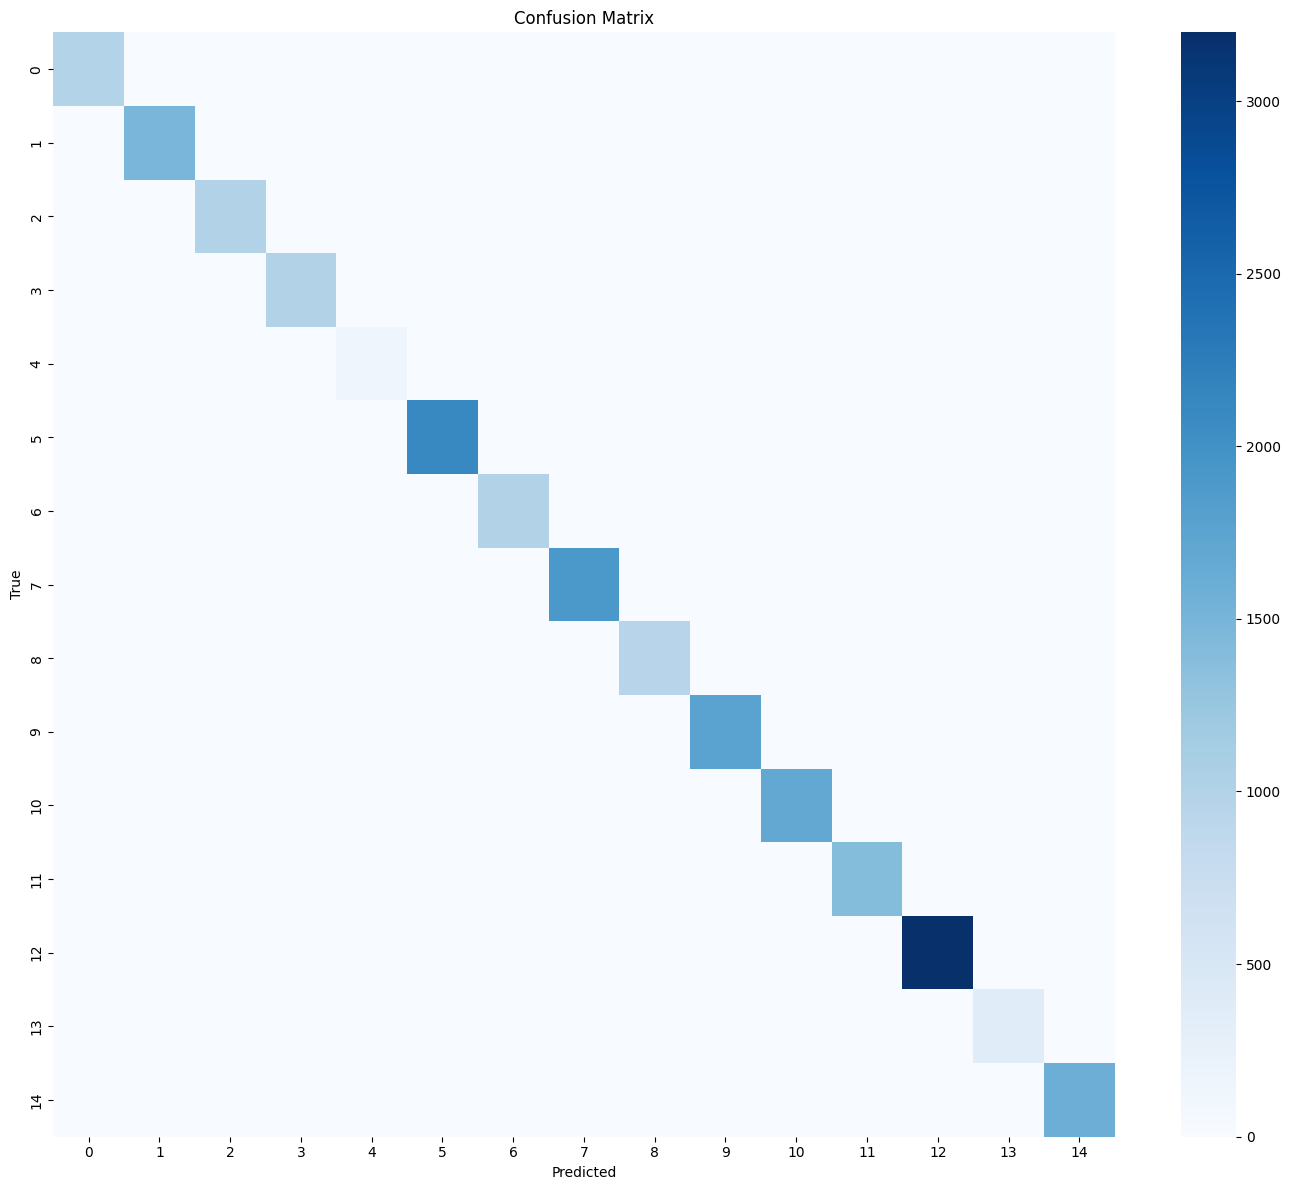

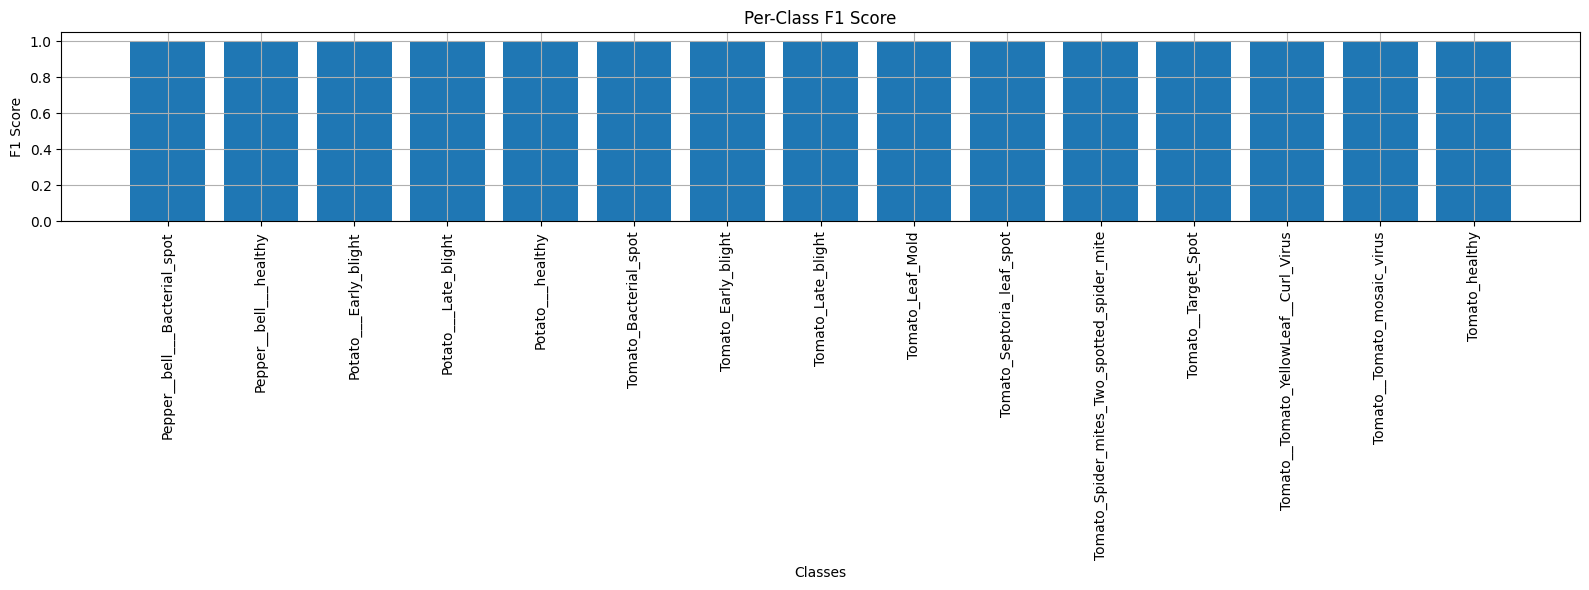

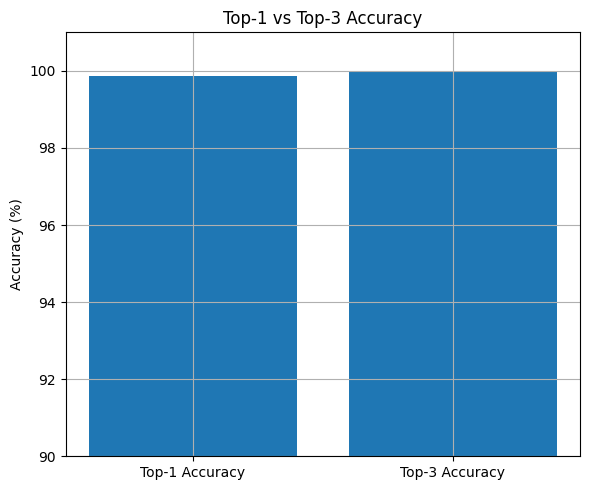

✅ All CNN Performance Graphs Generated Successfully!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# -------------------------------------------------
# ✅ CONFUSION MATRIX
# -------------------------------------------------

cm = confusion_matrix(all_labels, np.argmax(all_probs, axis=1))

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# ✅ PER-CLASS F1 SCORE
# -------------------------------------------------

class_f1 = f1_score(all_labels, y_pred, average=None)

plt.figure(figsize=(16, 6))
plt.bar(range(len(class_f1)), class_f1)
plt.xticks(range(len(class_f1)), class_names, rotation=90)
plt.title("Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.xlabel("Classes")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# ✅ TOP-1 vs TOP-3 ACCURACY
# -------------------------------------------------

acc_values = [top1_acc * 100, top3_acc * 100]
acc_labels = ["Top-1 Accuracy", "Top-3 Accuracy"]

plt.figure(figsize=(6, 5))
plt.bar(acc_labels, acc_values)
plt.title("Top-1 vs Top-3 Accuracy")
plt.ylabel("Accuracy (%)")
plt.ylim(90, 101)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ All CNN Performance Graphs Generated Successfully!")


In [ ]:
# ===========================================
# ✅ RAG RETRIEVAL ACCURACY TEST
# ===========================================

correct = 0
total = 0

for cnn_class in class_names:
    expected_title = CLASS_TO_TITLE.get(cnn_class)
    retrieved_block = rag._get_block_for_class(cnn_class)

    if expected_title is None:
        continue  # Skip if mapping missing

    retrieved_title = retrieved_block.splitlines()[0].replace(":", "").strip()

    if retrieved_title.lower() == expected_title.lower():
        correct += 1

    total += 1

rag_accuracy = correct / total

print("✅ RAG Retrieval Accuracy:", round(rag_accuracy * 100, 2), "%")
print("✅ Correct Matches:", correct, "/", total)


✅ RAG Retrieval Accuracy: 93.33 %
✅ Correct Matches: 14 / 15


In [ ]:
# ===========================================
# ✅ LLM FAITHFULNESS / HALLUCINATION CHECK
# ===========================================

def llm_faithfulness_score(answer, rag_block):
    rag_words = set(rag_block.lower().split())
    ans_words = set(answer.lower().split())

    overlap = len(rag_words & ans_words)
    score = overlap / len(rag_words)

    return score


# Test using last inference
rag_block = rag._get_block_for_class(prediction["disease"])
faithfulness = llm_faithfulness_score(answer, rag_block)

print("✅ LLM Faithfulness Score:", round(faithfulness * 100, 2), "%")


✅ LLM Faithfulness Score: 79.07 %


In [ ]:
prediction, answer = system.diagnose_and_advise(
    r"K:\cnndisease\00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG",
    "Recommend fertilizer"
)
print(answer)


Confirms Potato Late Blight. 
Symptoms: Dark greasy lesions, white mold under leaves, tuber rot.
Cause: Phytophthora infestans.
Organic Control: Neem oil (4 ml/L), copper oxychloride (3 g/L).
Prevention: Remove infected plants, avoid water stagnation.


In [ ]:
print("=== RAG DEBUG CHECK ===")
for cnn_class in class_names:
    expected = CLASS_TO_TITLE.get(cnn_class, "❌ Not in mapping")
    block = rag._get_block_for_class(cnn_class)
    retrieved = block.splitlines()[0].replace(":", "").strip()
    
    print("\nCNN Class:", cnn_class)
    print("Expected:", expected)
    print("Retrieved:", retrieved)
    
    if expected.lower() != retrieved.lower():
        print("❌ MISMATCH — FIX NEEDED")
    else:
        print("✅ OK")


=== RAG DEBUG CHECK ===

CNN Class: Pepper__bell___Bacterial_spot
Expected: Pepper Bell Bacterial Spot
Retrieved: Pepper Bell Bacterial Spot
✅ OK

CNN Class: Pepper__bell___healthy
Expected: Pepper Bell Healthy
Retrieved: Pepper Bell Healthy
✅ OK

CNN Class: Potato___Early_blight
Expected: Potato Early Blight
Retrieved: Potato Early Blight
✅ OK

CNN Class: Potato___Late_blight
Expected: Potato Late Blight
Retrieved: Potato Late Blight
✅ OK

CNN Class: Potato___healthy
Expected: Potato Healthy
Retrieved: Potato Healthy
✅ OK

CNN Class: Tomato_Bacterial_spot
Expected: Tomato Bacterial Spot
Retrieved: Tomato Bacterial Spot
✅ OK

CNN Class: Tomato_Early_blight
Expected: Tomato Early Blight
Retrieved: Tomato Early Blight
✅ OK

CNN Class: Tomato_Late_blight
Expected: Tomato Late Blight
Retrieved: Tomato Late Blight
✅ OK

CNN Class: Tomato_Leaf_Mold
Expected: Tomato Leaf Mold
Retrieved: Tomato Leaf Mold
✅ OK

CNN Class: Tomato_Septoria_leaf_spot
Expected: Tomato Septoria Leaf Spot
Retrieved: 